Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [1]:
# import pandas library as pd.
import pandas as pd 

# read in the LiverpoolFootballClub_all csv file.
LPFC = pd.read_csv('https://raw.githubusercontent.com/CVanchieri/LSDS-DataSets/master/EnglishPremierLeagueData/LiverpoolFootballClubData_EPL.csv')
# show the data frame shape.
print(LPFC.shape)
# show the data frame with headers.
LPFC.head()

(1003, 161)


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Attendance,Referee,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,AF,HO,AO,HY,AY,HR,AR,HBP,ABP,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,...,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,14/08/93,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,25/08/93,Liverpool,Tottenham,1,2,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,28/08/93,Liverpool,Leeds,2,0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,12/09/93,Liverpool,Blackburn,0,1,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,02/10/93,Liverpool,Arsenal,0,0,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# group the columns we want to use.
columns = ["Div", "Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", 
           "HTHG", "HTAG", "HTR", "HS", "AS", "HST", "AST", "HHW", "AHW", 
           "HC", "AC", "HF", "AF", "HO", "AO", "HY", "AY", "HR", "AR", "HBP", "ABP"]
# create a new data frame with just the grouped columns.
LPFC = LPFC[columns]
# relableing columns for better understanding.
LPFC = LPFC.rename(columns={"Div": "Division", "Date": "GameDate", "FTHG": "FullTimeHomeGoals", "FTAG": "FullTimeAwayGoals", 
                            "FTR": "FullTimeResult", "HTHG": "HalfTimeHomeGoals", "HTAG": "HalfTimeAwayGoals", "HTR": "HalfTimeResult", 
                            "HS": "HomeShots", "AS": "AwayShots", "HST": "HomeShotsOnTarget", "AST": "AwayShotsOnTarget", 
                            "HHW": "HomeShotsHitFrame", "AHW": "AwayShotsHitFrame", "HC": "HomeCorners", "AC": "AwayCorners", 
                            "HF": "HomeFouls", "AF": "AwayFouls", "HO": "HomeOffSides", "AO": "AwayOffSides", "HY": "HomeYellowCards", 
                           "AY": "AwayYellowCards", "HR": "HomeRedCards", "AR": "AwayRedCards", "HBP": "HomeBookingPoints_Y5_R10", 
                           "ABP": "AwayBookingPoints_Y5_R10"})
# show the data frame with headers.
print(LPFC.shape)
LPFC.head()

(1003, 28)


,Division,GameDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,HalfTimeHomeGoals,HalfTimeAwayGoals,HalfTimeResult,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeShotsHitFrame,AwayShotsHitFrame,HomeCorners,AwayCorners,HomeFouls,AwayFouls,HomeOffSides,AwayOffSides,HomeYellowCards,AwayYellowCards,HomeRedCards,AwayRedCards,HomeBookingPoints_Y5_R10,AwayBookingPoints_Y5_R10
0,E0,14/08/93,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,25/08/93,Liverpool,Tottenham,1,2,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,28/08/93,Liverpool,Leeds,2,0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,12/09/93,Liverpool,Blackburn,0,1,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,02/10/93,Liverpool,Arsenal,0,0,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3.  LogisticRegression model (cleaning/engineering).

## Train/test split the data frame, train/val/test.

In [0]:
df3 = LPFC.copy()

In [4]:
# import train_test_split from sklearn.model_selection library.
from sklearn.model_selection import train_test_split

target = 'FullTimeResult'
y = df3[target]

# split data into train, test.
X_train, X_val, y_train, y_val = train_test_split(df3, y, test_size=0.20,
                              stratify=y, random_state=42)
# show the data frame shapes.
print("train =", X_train.shape, y_train.shape, "val =", X_val.shape, y_val.shape)

train = (802, 28) (802,) val = (201, 28) (201,)


## Data cleaning & feature engineering.

In [0]:
import numpy as np
from datetime import datetime

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # prevent SettingWithCopyWarning with a copy.
    X = X.copy()
    

    # make 'GameDate' useable with datetime.
    X['GameDate'] = pd.to_datetime(X['GameDate'], infer_datetime_format=True) 
    
    # create new columns for 'YearOfGame', 'MonthOfGame', 'DayOfGame'.
    X['YearOfGame'] = X['GameDate'].dt.year
    X['MonthOfGame'] = X['GameDate'].dt.month
    X['DayOfGame'] = X['GameDate'].dt.day
    
    # removing 'FullTimeHomeGoals', 'FullTimeAwayGoals' as they directly coorelated to the result.
    dropped_columns = ['FullTimeHomeGoals', 'FullTimeAwayGoals', 'Division', 'GameDate']
    X = X.drop(columns=dropped_columns)
  
    # return the wrangled dataframe
    return X

X_train = wrangle(X_train)
X_val = wrangle(X_val)

In [0]:
# create the target as status_group.
target = 'FullTimeResult'
# set the features, remove target and id column.
train_features = X_train.drop(columns=[target])
# group all the numeric features.
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
# group the cardinality of the nonnumeric features.
cardinality = train_features.select_dtypes(exclude='number').nunique()
# group all categorical features with cardinality <= 100.
categorical_features = cardinality[cardinality <= 500].index.tolist()
# create features with numeric + categorical
features = numeric_features + categorical_features
# create the new vaules with the new features/target data.
X_train = X_train[features]
X_val = X_val[features]

In [7]:
!pip install category_encoders

     |████████████████████████████████| 102kB 4.4MB/s 


In [8]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print ('Training Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))
y_pred = pipeline.predict(X_val)

Training Accuracy 0.743142144638404
Validation Accuracy 0.6318407960199005


In [11]:
!pip install PDPbox

     |████████████████████████████████| 57.7MB 1.3MB/s 
  Created wheel for PDPbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=e64fe99ca772b7ef7b814ad1453a0be94262933e9e6039270ef6875bbf3194f4
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built PDPbox


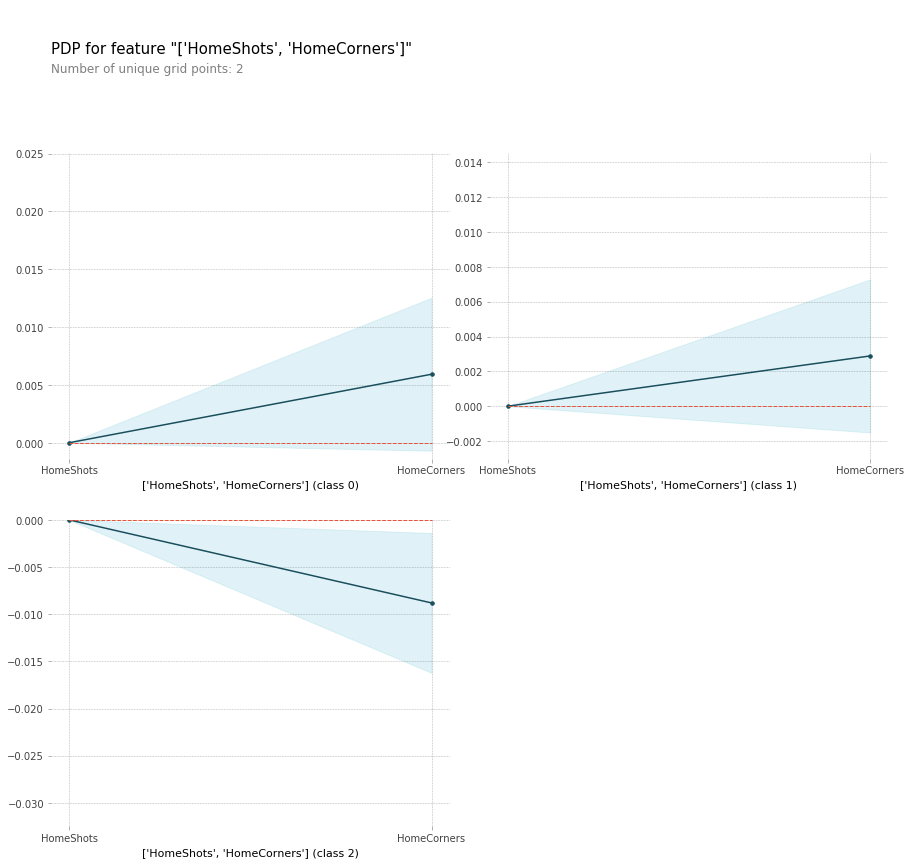

In [22]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = ['HomeShots', 'HomeCorners']

isolated = pdp_isolate(
    model = pipeline,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);